# QDA/LDA/RDA, and Gaussian Naive Bayes

As we explained in class generative models have the advantage that we obtain an estimation of the class conditioned probability distribution of the data $p(x|y=c_k)$.

In the case of generative models, we can use the learned distributions $p(x|y)$ for obtaining new data using sampling.

LDA and QDA assume that the classes correspond to gaussian distributions, so we are going to generate data according to that model
using scikit-learn's function `make_classification`; this method generates Gaussian-distributed classes in two dimensions so that
we can visualize the data, the resulting decision regions and their boundaries.

In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import collections
import numpy as np
from numpy.random import multivariate_normal
from sklearn.datasets import make_classification
from sklearn.base import ClassifierMixin, BaseEstimator
import scipy.stats
from scipy.stats.distributions import chi2
from scipy.special import logsumexp

## Generate data

In [2]:
K = 3 # 3 classes
X, y = make_classification(n_classes=K,
                           n_samples=1000,
                           n_features=2,
                           n_informative=2, 
                           n_redundant=0, 
                           class_sep=1.5, shift=7, n_clusters_per_class=1, random_state=0)

We have 3 Gaussian distributed classes as the next plot shows. 
From the picture, we can see that the Gaussians are not spherical or diagonal, and each have their own "shape". 
This suggests that QDA is going to be a better choice than LDA or Gaussian Naive Bayes.

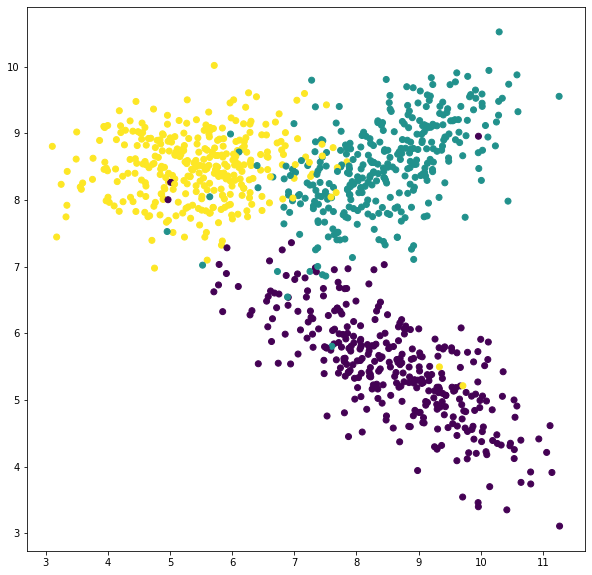

In [3]:
plt.figure(figsize=(10,10))
plt.scatter(X[:,0], X[:,1],c=y)

The following function allows us to visualize decision regions and boundaries of a trained classifier
which is going to be very useful

In [4]:
def draw_ellipse(mu, cov, confint=75):
    """eig decomp of linear transf given by mu, sigma at conf. level given by chisq, default is 75% conf.int."""
    lambdas, U  = np.linalg.eig(cov)
    idx = lambdas.argsort()[::-1]
    lambdas = lambdas[idx]
    U = U[:, idx]
    assert lambdas[0] >= lambdas[1], f'eigenvalues not sorted: {lambdas, U}'

    chisq = chi2.ppf(confint/100, df=2)            
    deg = (np.arctan2(U[1,0], U[0,0])*180/np.pi + 360) % 360
            
    ell = Ellipse((0, 0), width=chisq, height=chisq, fill=None, color='red', linewidth=2)
    transf = transforms.Affine2D()\
                .scale(np.sqrt(lambdas[0]), np.sqrt(lambdas[1]))\
                .rotate_deg(deg)\
                .translate(mu[0], mu[1])

    return ell, transf

def plot_regions(clf, X, y, prob=False):
    """
    Plots decision regions for a classifier over a dataset
    """
    # Create color maps
    h = .01  # step size in the mesh

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() , X[:, 0].max() 
    y_min, y_max = X[:, 1].min() , X[:, 1].max() 
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    if prob:
        Z = np.max(clf.predict_proba(np.c_[xx.ravel(), yy.ravel()]), axis=1)
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    if prob:
        plt.pcolormesh(xx, yy, Z.reshape(xx.shape),shading='auto', cmap='gray')
    else:
        plt.pcolormesh(xx, yy, Z.reshape(xx.shape), shading='auto', cmap='Set3')
        
    for v in clf.classes_:
        ell, transf = draw_ellipse(clf.means_[v], clf.cov_[v], confint=65)
        ell.set_transform(transf + ax.transData)
        ax.add_patch(ell)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', s=20)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

## Discriminant functions

Bayesian classifiers use **discriminant functions** to predict a class. In essence, these functions $g_k(\mathbf{x})$ are (some monotonic function) of $p(y=c_k|\mathbf{x})$. 
In the case of generative classifiers (QDA/LDA) and Naive Bayes, we use:

$$g_k(\mathbf{x})  = \log [p(\mathbf{x}|y=c_k) p(y=c_k)]  = \log p(\mathbf{x}|y=c_k) + \log p(y=c_k)  \propto p(y=c_k|\mathbf{x})$$

so the predicted class is just the class that maximizes likelihood of the class $c_k$ as the Bayes classifier suggests.

- In QDA, we assume that each $p(\mathbf{x}|y=c_k)$ is Gaussian distributed, and the discriminant functions are:

$$ g_k(\mathbf{x}) = \log \pi_k - \frac{1}{2}\left(\log|\Sigma_k|  + (\mathbf{x} - \mu_k)^T \Sigma_k^{-1}(\mathbf{x} - \mu_k)\right)$$

- In LDA, we assume that $p(x|y=c_k)$ is Gaussian with shared covariance matrix among all classes, and the discriminant functions are

$$g_k(\mathbf{x}) = \log \pi_k + \mu_k^T \Sigma^{-1}\mathbf{x} - \frac{1}{2}\mu_k^T\Sigma^{-1}\mu_k$$



### RDA classifier implementation

The following class implements RDA with parameters:
- alpha ($\alpha\in[0,1]$): allows to smoothly go from LDA (alpha=0) to QDA (alpha=1)
- gamma ($\gamma\in[0,1]$): regularizes covariance matrices by shrinking them towards an isotropic Gaussian
- diag (True/False): implements Gaussian Naive Bayes forcing final matrices to be diagonal

In [5]:
class MyRDAClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, alpha=1, gamma=0, diag=False):
        self.alpha = alpha
        self.gamma = gamma
        self.diag = diag
        return
    
    def fit(self, X, y):
        self.classes_ = np.unique(y)

        # estimates class proportions
        self.pi_ = {key:value/y.size for (key, value) in collections.Counter(y).items()} # class prior

        indices = {c:np.where(y == c) for c in self.classes_}
        
        # estimates class centers
        self.means_ = {}
        for c in self.classes_:
            self.means_[c] = np.mean(X[indices[c]], axis=0)
        
        # estimate covariance matrices
        self.cov_ = {}
        self.cov_['pooled'] = np.zeros((X.shape[1], X.shape[1]))
        for c in self.classes_:
            self.cov_[c] = np.cov(X[indices[c]], rowvar = False)
            self.cov_['pooled'] += self.pi_[c] * self.cov_[c] # ok, not quite what we said in class but close enough
        
        # regularize and/or drop off-diagonal..
        for c in self.classes_:
            self.cov_[c] = self.alpha * self.cov_[c] + (1-self.alpha) * self.cov_['pooled']
            if self.gamma > 0:
                sigma2 = np.trace(self.cov_[c]) / X.shape[1]
                self.cov_[c] = (1-self.gamma) * self.cov_[c] + self.gamma * sigma2 * np.identity(X.shape[1])
            if self.diag:
                self.cov_[c] = np.diag(np.diag(self.cov_[c]))
                
        return self
    
    def predict(self, X):
        g = np.zeros((X.shape[0], self.classes_.size))
        for i, c in enumerate(self.classes_):
            g[:,i] = np.log(self.pi_[c]) + scipy.stats.multivariate_normal.logpdf(X, mean=self.means_[c], cov=self.cov_[c])
            
        return self.classes_[g.argmax(axis=1)]
    
    def predict_proba(self, X):
        g = np.zeros((X.shape[0], self.classes_.size))
        for i, c in enumerate(self.classes_):
            g[:,i] = np.log(self.pi_[c]) + scipy.stats.multivariate_normal.logpdf(X, mean=self.means_[c], cov=self.cov_[c])

        # normalize using logsumexp trick
        log_g_norm = logsumexp(g, axis=1)  
        return np.exp(g - log_g_norm[..., np.newaxis])


### Fit models to data

In [15]:
lda = MyRDAClassifier(alpha=0, gamma=0)
lda.fit(X, y)

qda = MyRDAClassifier(alpha=1, gamma=0)
qda.fit(X, y)

isorda = MyRDAClassifier(alpha=1, gamma=0.5)
isorda.fit(X, y)

gnb = MyRDAClassifier(alpha=1, gamma=0, diag=True)
gnb.fit(X, y);

Just a small sanity check that our implementation is correct.. (compare predictions to `scikit-learn` implementations of LDA, QDA, and Gaussian NB

In [16]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

clf = LinearDiscriminantAnalysis(store_covariance=True)
clf.fit(X, y)

preds_lda = lda.predict_proba(X)
preds_sklda = clf.predict_proba(X)

clf = QuadraticDiscriminantAnalysis(store_covariance=True)
clf.fit(X, y)

preds_qda = qda.predict_proba(X)
preds_skqda = clf.predict_proba(X)

clf = GaussianNB()
clf.fit(X, y)

preds_gnb = gnb.predict_proba(X)
preds_skgnb = clf.predict_proba(X)

print('max diff in LDA:', np.max(np.abs(preds_lda - preds_sklda)))
print('max diff in QDA:', np.max(np.abs(preds_qda - preds_skqda)))
print('max diff in Gaussian NB:', np.max(np.abs(preds_gnb - preds_skgnb)))

max diff in LDA: 4.874993976611286e-06
max diff in QDA: 1.4432899320127035e-15
max diff in Gaussian NB: 0.0012335703648728158


## Look at estimated parameters for each model

In [17]:
lda.pi_, lda.means_, lda.cov_

({0: 0.334, 1: 0.336, 2: 0.33},
 {0: array([8.58981047, 5.4941169 ]),
  1: array([8.42487384, 8.51459551]),
  2: array([5.46647424, 8.47680202])},
 {'pooled': array([[ 1.06472692, -0.12201201],
         [-0.12201201,  0.48246413]]),
  0: array([[ 1.06472692, -0.12201201],
         [-0.12201201,  0.48246413]]),
  1: array([[ 1.06472692, -0.12201201],
         [-0.12201201,  0.48246413]]),
  2: array([[ 1.06472692, -0.12201201],
         [-0.12201201,  0.48246413]])})

In [18]:
qda.pi_, qda.means_, qda.cov_

({0: 0.334, 1: 0.336, 2: 0.33},
 {0: array([8.58981047, 5.4941169 ]),
  1: array([8.42487384, 8.51459551]),
  2: array([5.46647424, 8.47680202])},
 {'pooled': array([[ 1.06472692, -0.12201201],
         [-0.12201201,  0.48246413]]),
  0: array([[ 1.33667797, -0.69414569],
         [-0.69414569,  0.68047671]]),
  1: array([[0.92774839, 0.35834614],
         [0.35834614, 0.4693938 ]]),
  2: array([[ 0.92894853, -0.03203532],
         [-0.03203532,  0.29535937]])})

In [19]:
isorda.pi_, isorda.means_, isorda.cov_

({0: 0.334, 1: 0.336, 2: 0.33},
 {0: array([8.58981047, 5.4941169 ]),
  1: array([8.42487384, 8.51459551]),
  2: array([5.46647424, 8.47680202])},
 {'pooled': array([[ 1.06472692, -0.12201201],
         [-0.12201201,  0.48246413]]),
  0: array([[ 1.17262765, -0.34707284],
         [-0.34707284,  0.84452702]]),
  1: array([[0.81315974, 0.17917307],
         [0.17917307, 0.58398245]]),
  2: array([[ 0.77055124, -0.01601766],
         [-0.01601766,  0.45375666]])})

In [20]:
gnb.pi_, gnb.means_, gnb.cov_

({0: 0.334, 1: 0.336, 2: 0.33},
 {0: array([8.58981047, 5.4941169 ]),
  1: array([8.42487384, 8.51459551]),
  2: array([5.46647424, 8.47680202])},
 {'pooled': array([[ 1.06472692, -0.12201201],
         [-0.12201201,  0.48246413]]),
  0: array([[1.33667797, 0.        ],
         [0.        , 0.68047671]]),
  1: array([[0.92774839, 0.        ],
         [0.        , 0.4693938 ]]),
  2: array([[0.92894853, 0.        ],
         [0.        , 0.29535937]])})

### Generative models generate new data by sampling

Now we can sample the distributions. Fortunately numpy provides a function for that, we only have to provide the means and the covariance matrices.

In [21]:
def _sample(clf):
    s = []
    for v in clf.classes_:
        s.append(multivariate_normal(mean=clf.means_[v], cov=clf.cov_[v], size=int(X.shape[0] * clf.pi_[v])))
    return s

slda = _sample(lda)
sqda = _sample(qda)
srda = _sample(isorda)
sgnb = _sample(gnb)


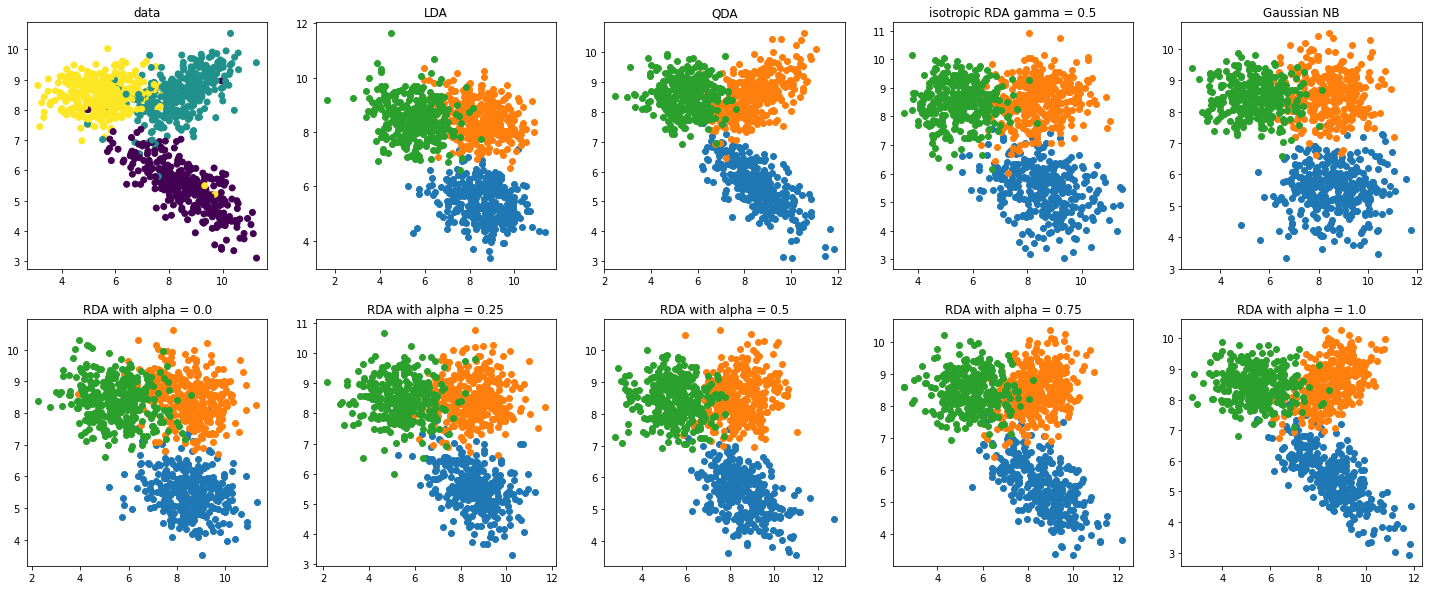

In [13]:
plt.figure(figsize=(25,10))

ax = plt.subplot(251)
plt.title("data")
plt.scatter(X[:,0], X[:,1], c=y)
    
ax = plt.subplot(252)
for v in np.unique(y):
    plt.scatter(slda[v][:,0], slda[v][:,1])
plt.title("LDA")

ax = plt.subplot(253)
for v in np.unique(y):
    plt.scatter(sqda[v][:,0], sqda[v][:,1])
plt.title("QDA")

ax = plt.subplot(254)
for v in np.unique(y):
    plt.scatter(srda[v][:,0], srda[v][:,1])
plt.title(f"isotropic RDA gamma = 0.5")

ax = plt.subplot(255)
for v in np.unique(y):
    plt.scatter(sgnb[v][:,0], sgnb[v][:,1])
plt.title("Gaussian NB")

for i, a in enumerate(np.linspace(0,1,5)):

    rda = MyRDAClassifier(alpha=a)
    rda.fit(X, y)
    srda = _sample(rda)
    ax = plt.subplot(2,5,6+i)
    for v in np.unique(rda.classes_):
        plt.scatter(srda[v][:,0], srda[v][:,1])
    plt.title(f'RDA with alpha = {a}')



### Visualizing decision regions and boundaries


Text(0.5, 1.0, 'Gaussian NB')

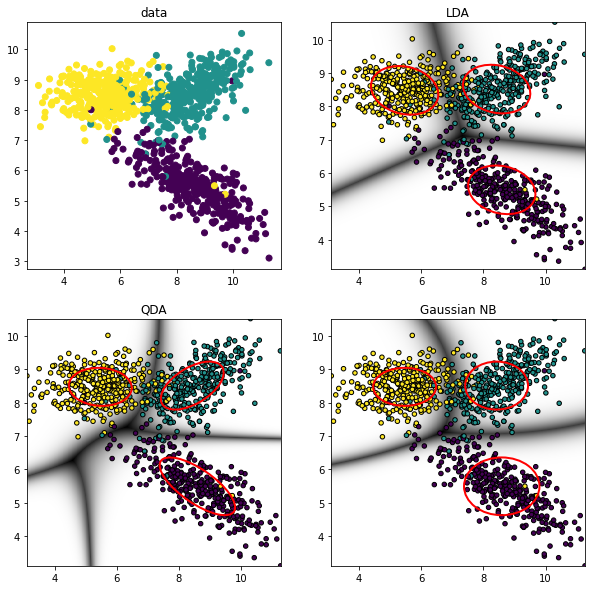

In [14]:
plt.figure(figsize=(10,10))

ax = plt.subplot(221)
plt.title("data")
plt.scatter(X[:,0], X[:,1], c=y)
    
ax = plt.subplot(222)
plot_regions(lda,X,y,prob=True)
plt.title("LDA")

ax = plt.subplot(223)
plot_regions(qda,X,y,prob=True)
plt.title("QDA")

ax = plt.subplot(224)
plot_regions(gnb,X,y,prob=True)
plt.title("Gaussian NB")